In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from hmmlearn import hmm
import os

## Read data from ticker

In [2]:
df = pd.read_csv('../data/aggregate/idx30.csv', delimiter=";", index_col=0)
filtered_colnames = [col[:4] for col in df.columns.tolist() if "Unnamed" not in col]

df = pd.read_csv('../data/aggregate/idx30.csv', delimiter=";", header=1, index_col=0)
df = df[pd.to_datetime(df.index, errors="coerce").notna()]

# Split the dataframe into adjusted close prices and volumes
adj_close_cols = [col for col in df.columns if 'PX_LAST' in col]
volume_cols = [col for col in df.columns if 'VOLUME' in col]

# Create separate dataframes
df_adj_close = df[adj_close_cols].apply(pd.to_numeric, errors='coerce')
df_volume = df[volume_cols].apply(pd.to_numeric, errors='coerce')

df_adj_close.index = pd.to_datetime(df_adj_close.index)
df_adj_close.columns = filtered_colnames
df_volume.index = pd.to_datetime(df_volume.index)
df_volume.columns = filtered_colnames

# Now resample the data to weekly frequency
df_adj_close_weekly = df_adj_close.resample('W').last().sort_index(ascending=False)

# Check earliest non NaN dates for each ticker
# earliest_dates = df_adj_close_weekly.apply(lambda x: x.dropna().index.min())



# SET CUTOFF DATE and cut to view the most recent data
date_threshold = pd.to_datetime('2010-10-10')
df_after = df_adj_close_weekly[df_adj_close_weekly.index >= date_threshold].dropna(axis=1) 

In [3]:
df_after

,ACES,ASII,ICBP,SMGR,ADRO,BBCA,INCO,MEDC,TLKM,AKRA,...,AMRT,BBRI,INKP,UNVR,ANTM,BMRI,ITMG,BRPT,KLBF,PTBA
Type,,,,,,,,,,,,,,,,,,,,,
2024-08-04,800,4630,10925.0,3910,3230,10325,3700,1310,2890,1515,...,2850,4670,8200,2430,1305,6425,26100,1095,1565,2660
2024-07-28,820,4610,10850.0,4010,3180,10325,3740,1325,3100,1555,...,2850,4760,8075,2490,1295,6550,26400,1065,1575,2660
2024-07-21,800,4530,10800.0,4060,3100,10125,3840,1285,3140,1515,...,2880,4900,8500,2800,1350,6525,26525,1055,1575,2630
2024-07-14,800,4540,10375.0,4090,2830,10075,3750,1315,3220,1500,...,2930,4900,8450,2920,1360,6425,25550,1130,1560,2530
2024-07-07,835,4580,10275.0,3950,2910,9950,4040,1390,3020,1565,...,2780,4800,8850,2910,1310,6425,26150,1220,1490,2540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-07,270,5670,2600.0,9274,2275,1420,4683,737,1570,310,...,190,1180,1940,3250,2184,1770,50500,124,590,4070
2010-10-31,270,5700,2850.0,9773,2100,1400,4683,775,1820,302,...,186,1112,2075,3490,2142,1721,45200,126,535,3930
2010-10-24,218,5615,2600.0,9773,2250,1370,4658,742,1800,310,...,185,1059,2100,3470,2163,1684,49500,128,520,4020


In [4]:
# 🧐 normalize from weekly pct change?? (weird)
# df_returns = df_adj_close_weekly.pct_change()
# df_returns = df_returns.iloc[1:]

# normalize from raw adj close weekly -> PCA only requires that the samples are demeaned
df_returns = df_after
returns_norm = (df_returns - df_returns.mean())/df_returns.std()

print("INCO mean", returns_norm['INCO'].mean())
print("INCO standard deviation", returns_norm['INCO'].std())

INCO mean -7.873049703713021e-17
INCO standard deviation 1.0000000000000013


In [5]:
returns_norm

,ACES,ASII,ICBP,SMGR,ADRO,BBCA,INCO,MEDC,TLKM,AKRA,...,AMRT,BBRI,INKP,UNVR,ANTM,BMRI,ITMG,BRPT,KLBF,PTBA
Type,,,,,,,,,,,,,,,,,,,,,
2024-08-04,-0.356811,-1.905753,1.221354,-2.108175,2.030192,2.183541,0.011454,2.360421,-0.295231,1.555802,...,2.398698,1.248268,0.680732,-1.685672,0.086213,2.565999,0.120219,1.462334,0.368857,-0.183032
2024-07-28,-0.309820,-1.924293,1.194178,-2.076023,1.964184,2.183541,0.039633,2.411187,-0.076651,1.671264,...,2.398698,1.314713,0.652823,-1.659805,0.070018,2.664907,0.145390,1.393140,0.395906,-0.183032
2024-07-21,-0.356811,-1.998455,1.176060,-2.059947,1.858571,2.107956,0.110081,2.275811,-0.035017,1.555802,...,2.437215,1.418071,0.747715,-1.526159,0.159089,2.645125,0.155879,1.370075,0.395906,-0.217340
2024-07-14,-0.356811,-1.989185,1.022060,-2.050302,1.502126,2.089060,0.046678,2.377343,0.048251,1.512504,...,2.501412,1.418071,0.736551,-1.474426,0.175283,2.565999,0.074070,1.543060,0.355332,-0.331701
2024-07-07,-0.274577,-1.952104,0.985824,-2.095314,1.607739,2.041819,0.250977,2.631173,-0.159920,1.700130,...,2.308823,1.344244,0.825860,-1.478737,0.094310,2.565999,0.124414,1.750642,0.165986,-0.320265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-07,-1.602079,-0.941648,-1.795240,-0.383539,0.769433,-1.181895,0.703958,0.421161,-1.669162,-1.922490,...,-1.016546,-1.328315,-0.716963,-1.332158,1.509721,-1.117316,2.167525,-0.777248,-2.268457,1.429449
2010-10-31,-1.602079,-0.913837,-1.704652,-0.223100,0.538403,-1.189453,0.703958,0.549768,-1.408948,-1.945583,...,-1.021681,-1.378517,-0.686821,-1.228691,1.441704,-1.156088,1.722823,-0.772635,-2.417228,1.269345
2010-10-24,-1.724256,-0.992634,-1.795240,-0.223100,0.736428,-1.200791,0.686346,0.438083,-1.429765,-1.922490,...,-1.022965,-1.417646,-0.681240,-1.237313,1.475712,-1.185365,2.083619,-0.768022,-2.457802,1.372269


## Slice and split data

In [7]:
switch = False

training_ratio = 0.8
split_point = int(np.round(returns_norm.shape[0] * training_ratio))

# returns_norm.iloc[:split_point].to_csv(f"{datadir}nopct_returns_train.csv")
# returns_norm.iloc[split_point:].to_csv(f"{datadir}nopct_returns_valid.csv")

train_df = returns_norm.iloc[:split_point]
valid_df = returns_norm.iloc[split_point:]

## Principal Component Analysis

- Max number of PCA components is argmin(n_samples, variables)

Columns with the lowest covariance to the rest of the group: Index(['KLBF', 'INDF', 'ACES', 'AKRA', 'TLKM'], dtype='object')


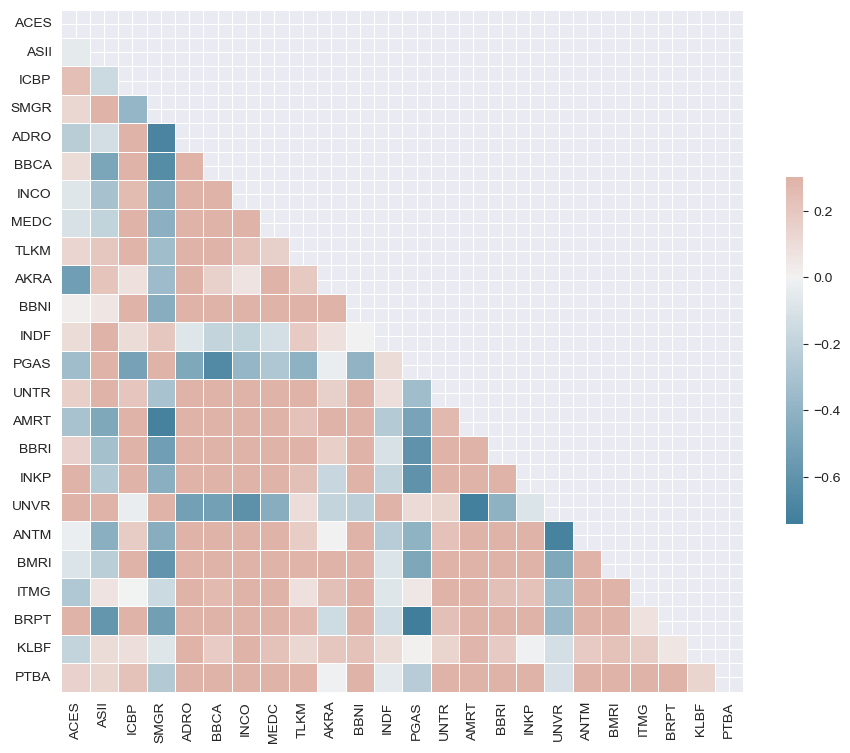

In [12]:
cov_matrix = train_df.cov()

# sum the absolute values of covariances for each column 
sum_abs_cov = cov_matrix.abs().sum(axis=1)

sorted_columns = sum_abs_cov.sort_values().index
lowest_cov_columns = sorted_columns[:5]

print("Columns with the lowest covariance to the rest of the group:", lowest_cov_columns)

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(cov_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cov_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Covariance takeaways 

Normalized percent change dataframe
- PGEO, AMRT, ARTO seems to have pretty low covariance with everything else -> Could be interesting to isolate profit tests on these assets
- PGEO AMRT and Arto seems to have pretty low contributions

Normalized raw adjusted close price dataframe 
- SMGR, UNVR, PGAS

## HMM Paper Takeaways

- GMM is used to capture multivariate data -> could be possibly used for encoding adj close percentage change & volume at the same time??
- GMM is a weighted sum of multiple Gaussian distributions, where each component represents a subpopulation within the data

In [9]:
train_df.dropna()

,ACES,ASII,ICBP,SMGR,ADRO,BBCA,INCO,MEDC,TLKM,AKRA,...,AMRT,BBRI,INKP,UNVR,ANTM,BMRI,ITMG,BRPT,KLBF,PTBA
Type,,,,,,,,,,,,,,,,,,,,,
2024-08-04,-0.356811,-1.905753,1.221354,-2.108175,2.030192,2.183541,0.011454,2.360421,-0.295231,1.555802,...,2.398698,1.248268,0.680732,-1.685672,0.086213,2.565999,0.120219,1.462334,0.368857,-0.183032
2024-07-28,-0.309820,-1.924293,1.194178,-2.076023,1.964184,2.183541,0.039633,2.411187,-0.076651,1.671264,...,2.398698,1.314713,0.652823,-1.659805,0.070018,2.664907,0.145390,1.393140,0.395906,-0.183032
2024-07-21,-0.356811,-1.998455,1.176060,-2.059947,1.858571,2.107956,0.110081,2.275811,-0.035017,1.555802,...,2.437215,1.418071,0.747715,-1.526159,0.159089,2.645125,0.155879,1.370075,0.395906,-0.217340
2024-07-14,-0.356811,-1.989185,1.022060,-2.050302,1.502126,2.089060,0.046678,2.377343,0.048251,1.512504,...,2.501412,1.418071,0.736551,-1.474426,0.175283,2.565999,0.074070,1.543060,0.355332,-0.331701
2024-07-07,-0.274577,-1.952104,0.985824,-2.095314,1.607739,2.041819,0.250977,2.631173,-0.159920,1.700130,...,2.308823,1.344244,0.825860,-1.478737,0.094310,2.565999,0.124414,1.750642,0.165986,-0.320265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-11,-0.474289,0.013186,-0.644767,1.732710,-1.375839,-0.909788,-1.358760,-0.851373,-0.805251,-0.233859,...,-0.425940,-1.018239,-0.871022,-0.021571,-0.407723,-0.796856,0.040508,-0.966379,0.057789,-0.937811
2013-08-04,-0.474289,0.013186,-0.644767,1.732710,-1.375839,-0.909788,-1.358760,-0.851373,-0.805251,-0.233859,...,-0.425940,-1.018239,-0.871022,-0.021571,-0.407723,-0.796856,0.040508,-0.966379,0.057789,-0.937811
2013-07-28,-0.521281,-0.218570,-0.690062,1.556196,-1.296629,-0.936242,-1.212932,-0.858142,-0.878111,-0.060666,...,-0.445199,-1.033004,-0.904514,0.107764,-0.339706,-0.786569,0.074070,-0.964072,-0.185655,-0.743398


In [11]:
def pcap(norm_returns, p=0.30):
    """
    PCA with denoising factor p -> (1-p) variance
    
    :param norm_returns: Dataframe of normalized returns 
    :param p: Maximum number of noise to extract/remove from the data
    :return:  PCA object, explained variance ratios, and data with reduced dimensionality   
    """
    # Compute covariance matrix
    cov_matrix = norm_returns.cov()
    
    # Eigendecomposition of the variables into eigenvalues, eigenvectors
    
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = idx
    eigenvectors = eigenvectors[:, idx]
    
    # calculate cumulative explained variance ratio
    total_variance = np.sum(eigenvalues)
    cumulative_variance_ratio = np.cumsum(eigenvalues) / total_variance 
    
    # Determine the number of components to keep 
    k = np.argmax(cumulative_variance_ratio >= (1 - p )) + 1
    
    print("Number of PCA Components: ", k)
    
    # Create PCA object and fit
    pca = PCA(n_components=k)
    reduced_data = pca.fit_transform(norm_returns)
    
    return pca, cumulative_variance_ratio, reduced_data

## Plotting functions

In [ ]:
cumulative_variance_ratio

In [ ]:
def plot_scree(cumulative_variance_ratio):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Scree Plot')
    plt.grid()
    plt.show()

def plot_explained_variance(pca):
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Plot')
    plt.grid()
    plt.show()

def plot_biplot(pca, reduced_data, labels=None):
    plt.figure(figsize=(10, 6))
    xs = reduced_data[:, 0]
    ys = reduced_data[:, 1]
    plt.scatter(xs, ys)
    for i, (x, y) in enumerate(zip(xs, ys)):
        plt.text(x, y, labels[i] if labels is not None else i)
    feature_vectors = pca.components_.T
    for i, v in enumerate(feature_vectors):
        plt.arrow(0, 0, v[0], v[1], head_width=0.1, head_length=0.1, linewidth=2, color='red')
        plt.text(v[0], v[1], f"Var{i+1}", color='red')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Biplot')
    plt.grid()
    plt.show()

def plot_score_plot(reduced_data, labels=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Score Plot')
    plt.colorbar()
    plt.grid()
    plt.show()

def plot_cumulative_explained_variance(cumulative_variance_ratio):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance Plot')
    plt.grid()
    plt.show()


In [ ]:
pca, cumvar, reduced = pcap(train_df, p=0.45)

# # Plot Scree Plot
# plot_scree(cumulative_variance_ratio)

# Plot Explained Variance
plot_explained_variance(pca)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# # Plot PCA Biplot (assuming you have some labels, replace 'None' with your labels if available)
# plot_biplot(pca, reduced_data, labels=None)
# 
# # Plot Cumulative Explained Variance
# plot_cumulative_explained_variance(cumulative_variance_ratio)
# 
# # Plot Score Plot (assuming you have some labels, replace 'None' with your labels if available)
# plot_score_plot(reduced_data, labels=None)

In [ ]:
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [ ]:
import numpy as np
from hmmlearn import hmm

def train_and_select_hmm(factor_returns, max_states=8):
    """
    Train HMM models with different numbers of states and select the best one based on AIC
    
    :param factor_returns: PCA factor returns
    :param max_states: Maximum number of states to consider
    :return: Best HMM model
    """
    best_model = None
    best_aic = np.inf

    for n_states in range(2, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)

        try:
            model.fit(factor_returns)
            # Calculate AIC manually
            log_likelihood = model.score(factor_returns)
            n_params = n_states * (n_states - 1) + 2 * n_states * factor_returns.shape[1] - 1
            aic = -2 * log_likelihood + 2 * n_params

            if aic < best_aic:
                best_aic = aic
                best_model = model
        except:
            continue

    return best_model

# Example usage (assuming `reduced_data` is defined)
# reduced_data should be your PCA factor returns data
best_hmm = train_and_select_hmm(reduced_data)


In [ ]:
best_hmm

In [ ]:
def evaluate_performance(returns, strategy_returns):
    """
    Evaluate the performance of a trading strategy
    
    :param returns: Benchmark returns (buy-and-hold)
    :param strategy_returns: Strategy returns
    :return: Performance metrics
    """
    # Calculate winning probability
    winning_prob = np.mean(strategy_returns > 0)

    # Calculate annualized Sharpe ratio
    sharpe_ratio = np.sqrt(52) * strategy_returns.mean() / strategy_returns.std()

    # Calculate cumulative returns
    cumulative_returns = (1 + strategy_returns).cumprod()

    return winning_prob, sharpe_ratio, cumulative_returns

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

tipe2 product reksadana
kriteria masing2 product
apa yg pengaruhi pergerakan bonds
fed stuff + trump/kamala -> impact??